In [1]:
import os
directory = os.path.expanduser('~/xtmp/ConceptWhitening/ConceptWhitening')
os.chdir(directory)
print(f"Current working directory: {os.getcwd()}, should end in /ConceptWhitening")


Current working directory: /usr/project/xtmp/rnb23/ConceptWhitening/ConceptWhitening, should end in /ConceptWhitening


In [2]:
import os

from data.datasets import BackboneDataset, CWDataset
from models.ResNet50 import ResNet, res50

import os
import json
import yaml
import time
import textwrap
import pandas as pd
from PIL import ImageFile
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.backends import cudnn
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm
import matplotlib.pyplot as plt


with open("config.yaml", 'r') as file:
    CONFIG = yaml.safe_load(file)

# Set the random seeds for reproducibility
torch.manual_seed(CONFIG["seed"])
torch.cuda.manual_seed_all(CONFIG["seed"])

# https://stackoverflow.com/questions/58961768/set-torch-backends-cudnn-benchmark-true-or-not
cudnn.benchmark = True

In [3]:
cub_path = "/usr/project/xtmp/cs474_cv/ConceptWhitening/coco_dataset"
train_df = pd.read_parquet(os.path.join(cub_path, CONFIG["directories"]["data"], "train.parquet"))
train_df = train_df[:10000]
test_df = pd.read_parquet(os.path.join(cub_path, CONFIG["directories"]["data"], "test.parquet"))
test_df = test_df[:1000]
# Ensure reproducibility
train_df, val_df = train_test_split(train_df, test_size=len(test_df), random_state=CONFIG["seed"])

# Tell PIL not to skip truncated images, just try its best to get the whole thing
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the low and high level concept dictionaries
low_path = os.path.abspath(CONFIG["directories"]["low_concepts"])
# high_path = os.path.abspath(CONFIG["directories"]["high_concepts"])
mappings_path = os.path.abspath(CONFIG["directories"]["mappings"])
with open(low_path, "r") as file:
    low_level = json.load(file)
"""with open(high_path, "r") as file:
    high_level = json.load(file)"""
with open(mappings_path, "r") as file:
    mappings = json.load(file)

In [4]:
train_loader = DataLoader(
    BackboneDataset(
        annotations=train_df,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=CONFIG["train"]["batch_size"],
    shuffle=True,
    num_workers=CONFIG["train"]["workers"]
)

# Validation
val_loader = DataLoader(
    BackboneDataset(
        annotations=val_df,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=CONFIG["train"]["batch_size"],
    shuffle=False,
    num_workers=CONFIG["train"]["workers"]
)

# Test
test_loader = DataLoader(
    BackboneDataset(
        annotations=test_df,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=CONFIG["train"]["batch_size"],
    shuffle=False,
    num_workers=CONFIG["train"]["workers"]
)

In [5]:
sample = next(iter(train_loader))
print(type(sample))
print(sample)

<class 'list'>
[tensor([[[[0.5529, 0.5529, 0.5529,  ..., 0.5608, 0.5608, 0.5608],
          [0.5529, 0.5529, 0.5529,  ..., 0.5608, 0.5608, 0.5608],
          [0.5529, 0.5529, 0.5529,  ..., 0.5608, 0.5608, 0.5608],
          ...,
          [0.3529, 0.3608, 0.3529,  ..., 0.2980, 0.2941, 0.3098],
          [0.3569, 0.3608, 0.3529,  ..., 0.3255, 0.3255, 0.3412],
          [0.3529, 0.3569, 0.3490,  ..., 0.3490, 0.3490, 0.3686]],

         [[0.7529, 0.7529, 0.7529,  ..., 0.7608, 0.7608, 0.7608],
          [0.7529, 0.7529, 0.7529,  ..., 0.7608, 0.7608, 0.7608],
          [0.7529, 0.7529, 0.7529,  ..., 0.7608, 0.7608, 0.7608],
          ...,
          [0.4431, 0.4510, 0.4431,  ..., 0.3922, 0.3882, 0.4039],
          [0.4392, 0.4431, 0.4353,  ..., 0.4196, 0.4196, 0.4353],
          [0.4353, 0.4392, 0.4314,  ..., 0.4431, 0.4431, 0.4627]],

         [[0.8745, 0.8745, 0.8745,  ..., 0.8745, 0.8745, 0.8745],
          [0.8745, 0.8745, 0.8745,  ..., 0.8745, 0.8745, 0.8745],
          [0.8745, 0.8745,

In [6]:
for batch_idx, batch in enumerate(train_loader):
    labels = batch[2]
    print(f"batch {batch_idx}: labels shape = {labels.shape}")
    print(f"labels values: {labels[:5]}")
    break

batch 0: labels shape = torch.Size([128])
labels values: tensor([ 0, 16,  0, 49, 26])


(94, 10)


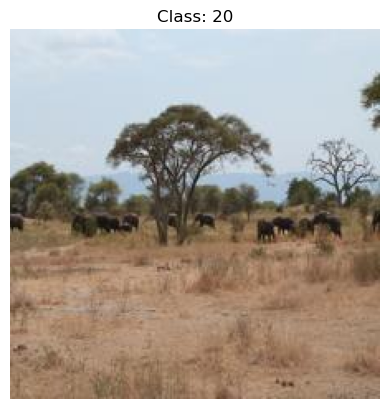

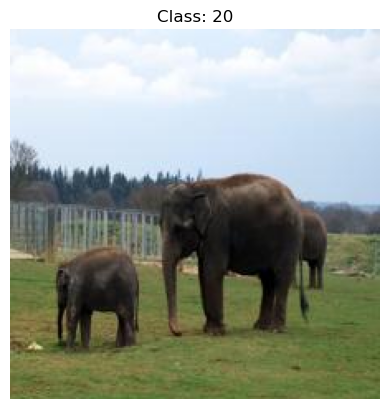

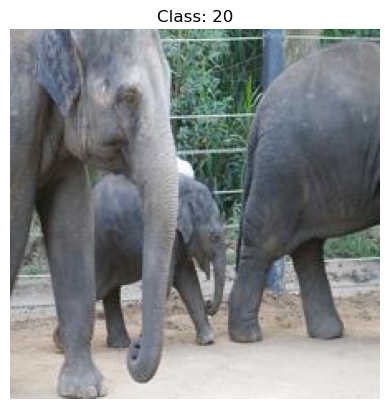

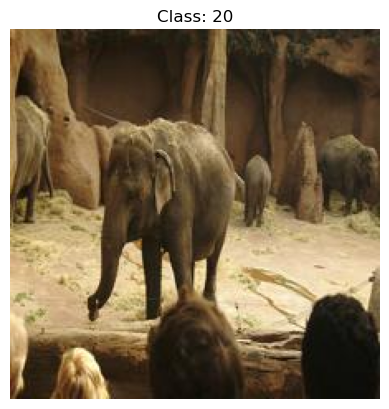

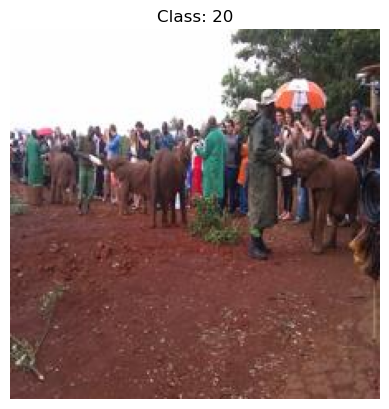

In [8]:
from PIL import Image

class_name = 20
class_df = train_df[train_df['class'] == class_name]
print(class_df.shape)

if class_df.empty:
    print(f"No images found for class '{class_name}'.")

# Select 5 random paths
sample_paths = class_df['path'].sample(min(5, len(class_df))).tolist()

for path in sample_paths:
    try:
        image = Image.open(path).convert('RGB')
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Class: {class_name}")
        plt.show()
    except Exception as e:
        print(f"Error loading image at {path}: {e}")

In [13]:
 """train_df_free, free_low_level, free_mappings = CWDataset.make_free_concepts(train_df, 2, low_level,
                                                                                high_level, mappings)"""
# TODO: Changed all free_low_level and free_mappings to the defaults
high_to_low, low_level_names = CWDataset.generate_low_level_cw_mappings(low_level, mappings)
min_concept = min(low_level.values())
max_concept = max(low_level.values())

concept_loaders = []
for i in range(min_concept, max_concept + 1):
    concepts = CWDataset(
        # train_df_free, low_level, mode=i,
        train_df, low_level, mode=i,
        transform=transforms.Compose([transforms.ToTensor()])
    )

    # Sometimes concepts are not in the training set, so we temporarily skip them.
    # This can be better addressed in the future.
    if len(concepts) == 0:
        continue

    # Notice that num workers is not set. If there are hundreds of concepts,
    # using lots of workers per concept is not practical.
    concept_loader = DataLoader(
        concepts,
        batch_size=CONFIG["train"]["batch_size"],
        shuffle=True
    )
    concept_loaders.append(concept_loader)

/usr/project/xtmp/rnb23/ConceptWhitening/ConceptWhitening/data/datasets.py:90: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.annotations["low_level"] = self.annotations["low_level"].replace(self.low_level).infer_objects(copy=False)


In [14]:
print(f"Number of available GPUs: {torch.cuda.device_count()}")

Number of available GPUs: 1


In [1]:
 model = res50(
    whitened_layers=CONFIG["cw_layer"]["whitened_layers"],
    high_to_low=high_to_low,
    cw_lambda=CONFIG["cw_layer"]["cw_lambda"],
    activation_mode=CONFIG["cw_layer"]["activation_mode"],
    pretrained_model=CONFIG["directories"]["model"],
    vanilla_pretrain=CONFIG['train']['vanilla']
)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=CONFIG["optim"]["lr"],
    momentum=CONFIG["optim"]["momentum"],
    weight_decay=CONFIG["optim"]["l2"])
scheduler = StepLR(optimizer, step_size=CONFIG["optim"]["lr_step"], gamma=CONFIG["optim"]["lr_gamma"])

model = torch.nn.DataParallel(model, device_ids=list(range(1))) ## changed to 1 for my setup change back to 2 later
model = model.cuda()

# =========================
# Print Training Parameters
# =========================
print(
    "\nTraining parameters:\n"
    f"cw_layer:\n{textwrap.indent(yaml.dump(CONFIG['cw_layer'], default_flow_style=False), '  ')}\n"
    f"train:\n{textwrap.indent(yaml.dump(CONFIG['train'], default_flow_style=False), '  ')}\n"
    f"optim:\n{textwrap.indent(yaml.dump(CONFIG['optim'], default_flow_style=False), '  ')}"
)

# =============
# Training Loop
# =============
if CONFIG["verbose"]:
    print("Starting training...")

best_acc = 0
best_path = None
accs = []



KeyboardInterrupt



In [16]:

def save_checkpoint(state):
    """
    Save the model in a compatible format with the ResNet50 `load_model` method.

    Params:
    - state (dict): Dictionary with keys [epoch, acc, state_dict]. Contains the model's state information.

    Returns:
        str: Path to the saved model file.
    """
    path = os.path.join(CONFIG["directories"]["checkpoint"],
                        f"{CONFIG['train']['checkpoint_prefix']}_epoch_{state['epoch']}_acc_{state['acc']:.4f}.pth")
    torch.save(state["state_dict"], path)
    return path


def top_k_correct(output, target: torch.Tensor, k=1):
    """
    See how many predictions were in the top k predicted classes. Assumes target is already adjusted to be -1 for CUB.
    """
    _, predicted_topk = torch.topk(output, k, dim=1)
    correct_topk = (predicted_topk == target.unsqueeze(1)).sum().item()
    return correct_topk


def top_k_activated_concepts(concept_loaders, data_loader: DataLoader[BackboneDataset], model: nn.DataParallel[ResNet],
                             output_path: str, low_level_names: dict[int, str], k=50):
    """
    This should only be run at the end of the training cycle, as it sets the model to evaluation mode.
    The activations in the last CW layers will be considered.
    """
    model.eval()
    with torch.no_grad():
        # Update the gradient matrix G for the concept whitening layers.
        # Each concept in the CWLayer is indexed by its corresponding position in concept_loaders.
        for idx, concept_loader in enumerate(concept_loaders):
            # if idx not in CONFIG['train']['allowed_concepts']:
            #    continue
            model.module.change_mode(idx)

            for batch, region in concept_loader:
                batch: torch.Tensor
                batch = batch.cuda()
                model(batch, region, batch.shape[2])  # batch.shape[2] gives the original x dimension
                break  # only sample one batch for each concept

        model.module.reset_counters()
        # Stop computing the gradient for concept whitening.
        # mode=-1 is the default mode that skips gradient computation.
        model.module.change_mode(-1)

    idx = -1
    last_cw_layer = model.module.cw_layers[idx]

    hook = last_cw_layer.register_forward_hook(ResNet.get_X_activated)
    output = {}

    model.eval()
    with torch.no_grad():
        for input, path, target in data_loader:
            input: torch.Tensor
            target: torch.Tensor

            input = input.cuda()
            target = target.cuda()

            # List of torch.Tensors of size batch_size x k, each corresponding to a relevant CW layer
            batch_top_k_vals, batch_top_k_concepts = model.module.top_k_activated_concepts(input, k, idx)
            batch_top_k_vals = batch_top_k_vals.cpu()
            batch_top_k_concepts = batch_top_k_concepts.cpu()

            # Loops through each image in the batch
            for image_index in range(input.shape[0]):
                image_path = path[image_index]
                top_k_concepts = batch_top_k_concepts[image_index].tolist()
                top_k_vals = batch_top_k_vals[image_index].tolist()

                # Translates from concept index to concept name
                top_k_names = list(low_level_names[concept] for concept in top_k_concepts)

                output[image_path] = [top_k_vals, top_k_names]

    hook.remove()

    with open(output_path, 'w') as json_file:
        json.dump(output, json_file, indent=4)
    print(f"Top k activated concepts outputs have been saved to '{output_path}'")

In [17]:
for batch_idx, batch in enumerate(train_loader):
    labels = batch[2]
    print(f"batch {batch_idx}: labels shape = {labels.shape}")
    print(f"labels values: {labels[:5]}")
    break

batch 0: labels shape = torch.Size([128])
labels values: tensor([ 0, 31, 15, 13, 19])


In [18]:
import random as random
# When running this block multiple times without restarting the kernel first I run out of vram this indicates some kind of memory mismanagement maybe we free everything at the end of the training loop but thats still bad practice.
def train(
    train_loader: DataLoader,
    concept_loaders: list[DataLoader],
    model: nn.DataParallel[ResNet],
    criterion: nn.modules.loss._Loss,
    optimizer: torch.optim.Optimizer
):
    """
    Trains the model for one epoch.
    """
    start = time.time()
    total_loss = 0
    total_correct = 0
    model.train()

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", unit="batch")

    for i, (inp, _, target) in progress_bar:
        inp: torch.Tensor
        target: torch.Tensor
        # print(f'shape: {inp.shape} \n item:{inp[0]}')
        # NOTE: CUB dataset labels start at 1, hence this line. If your target starts at zero, this needs to be removed!
        #target = target - 1

        batch_size = inp.size(0)
        random_index = random.randint(0, batch_size - 1)

        # Select the random image
        random_image = inp[random_index]
        target_n_shiii = target[random_index].item()

        # Convert the image from (C, H, W) to (H, W, C) for displaying
        image_np = random_image.permute(1, 2, 0).cpu().numpy()

        # If the image has more than 1 channel, normalize to [0, 1] for display
        if image_np.shape[2] > 1:
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

        # Display the image
        plt.imshow(image_np)
        plt.axis('off')
        plt.title(f"Image at index {random_index} of {low_level_names[target_n_shiii]} ({target_n_shiii})")
        plt.show()


        # Train for concept whitening loss once every train_cw_freq batches.
        if (i + 1) % 2 == 0: # CONFIG["train"]["train_cw_freq"] == 0: # Russ Note: Why is this disabled, this is when we update the concept gradients no? seems important!?
            # model.eval() # Russ Note: just testing to see if this changes anything not sure why we are puttin it in eval or turning off gradient accumulation, I mean I get that CW doesnt use torches gradient stuff but why turn it off?
            with torch.no_grad():
                # Update the gradient matrix G for the concept whitening layers.
                # Each concept in the CWLayer is indexed by its corresponding position in concept_loaders.
                for idx, concept_loader in enumerate(concept_loaders):
                    # if idx not in CONFIG['train']['allowed_concepts']:
                    #    continue
                    model.module.change_mode(idx)

                    for concept_batch, region in concept_loader:
                        concept_batch: torch.Tensor
                        concept_batch = concept_batch.cuda()
                        model(concept_batch, region, concept_batch.shape[2])  # batch.shape[2] gives the original x dimension
                        break  # only sample one batch for each concept

                model.module.update_rotation_matrix()
                # Stop computing the gradient for concept whitening.
                # A mode of -1 is the default mode that skips gradient computation.
                model.module.change_mode(-1)
            # model.train()

        # Move them to CUDA, assumes CUDA access
        # print(f'shape: {inp.shape} \n item:{inp[0]}')
        inp = inp.cuda()
        target = target.cuda()

        # Forward pass + loss computation
        output = model(inp)
        loss: torch.Tensor = criterion(output, target)

        # Performance metrics
        total_loss += loss.item() # Russ Note: should we include CW loss in this loss calc or are we just not tracking it?
        total_correct += top_k_correct(output, target) # Russ Note: I think a .item() should be here to detach tensors

        # Calculate CW loss once every train_cw_freq batches
        if (i + 1) % 2 == 0: #CONFIG["train"]["train_cw_freq"] == 0:
            model.module.reset_counters()
            # model.eval() # Russ Note: just testing to see if this changes anything not sure why we are puttin it in eval or turning off gradient accumulation, I mean I get that CW doesnt use torches gradient stuff but why turn it off?
            with torch.no_grad():
                # Each concept in the CWLayer is indexed by its corresponding position in concept_loaders.
                for idx, concept_loader in tqdm(enumerate(concept_loaders), desc="CW"): # Russ Note: its insane how long this loop runs. 99% of the time is spent just going through this. Figuring out how to move concept loaders to the gpu is essential
                    # print(f"concept loader: {idx}") # Russ Note: Script seems stuck on the second concept loader in this loop. Is that one like super long?
                    # if idx not in CONFIG['train']['allowed_concepts']:
                    #     continue
                    model.module.change_mode(idx)

                    for concept_batch, region in concept_loader:
                        concept_batch: torch.Tensor
                        concept_batch = concept_batch.cuda() # Russ Note: why do we keep using .cuda instead of .to(device) seems like bad practice
                        model(concept_batch, region, concept_batch.shape[2])  # batch.shape[2] gives the original x dimension

                # Stop computing the gradient for concept whitening.
                # A mode of -1 is the default mode that skips gradient computation.
                model.module.change_mode(-1)
            # model.train()

            # This is really CW score not loss. We want to maximize axis alignment. Hence the minus
            print(f"Main objective loss: {loss.item()}", flush=True)

            cw_loss = model.module.cw_loss() # Russ Note: add .item() here? Is there some reason we are keeping everything in tensor form like this happens everywhere!
            print(f"CW score: {cw_loss}", flush=True)

            loss -= CONFIG["train"]["cw_loss_weight"] * cw_loss
            model.module.reset_counters()

        # Compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end = time.time()
    avg_loss = total_loss / len(train_loader)
    acc = total_correct / len(train_loader.dataset)
    # torch.cuda.empty_cache() # Russ Note: maybe add this to avoid potential memory leaks or maybe gc.collect() we definitely need some detaches in here
    return avg_loss, acc, end - start

Training:   0%|          | 0/12 [00:00<?, ?batch/s]

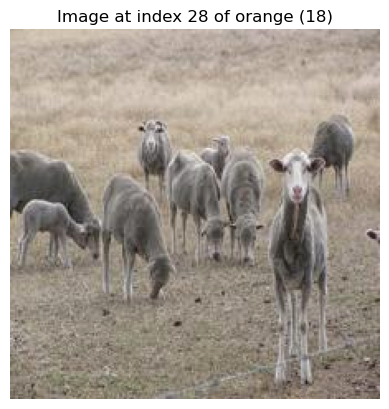

/usr/project/xtmp/rnb23/ConceptWhitening/ConceptWhitening/models/IterNorm.py:31: UserWarning: This overload of baddbmm is deprecated:
	baddbmm(Number beta, Tensor input, Number alpha, Tensor batch1, Tensor batch2, *, Tensor out = None)
Consider using one of the following signatures instead:
	baddbmm(Tensor input, Tensor batch1, Tensor batch2, *, Number beta = 1, Number alpha = 1, Tensor out = None) (Triggered internally at /opt/conda/conda-bld/pytorch_1720538438429/work/torch/csrc/utils/python_arg_parser.cpp:1581.)
  Sigma = torch.baddbmm(eps, P[0], 1. / m, xc, xc.transpose(1, 2))
Training:   8%|▊         | 1/12 [00:03<00:41,  3.73s/batch]

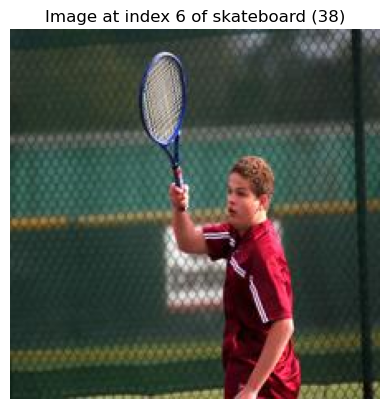

Training:   8%|▊         | 1/12 [00:13<02:28, 13.47s/batch]


KeyboardInterrupt: 

In [19]:
for epoch in range(1):
    # Train and validate an epoch
    _, train_acc, train_duration = train(train_loader, concept_loaders, model, criterion, optimizer)
    accs.append(validate(val_loader, model, criterion)[1]) # Russ Note: should we not do .item to detach tensors

    # Learning rate scheduler step. Every 30 epochs, learning rate lr is divided by 5.
    scheduler.step()

    # Compute average accuracy of last 5 epochs
    num_epochs = len(accs)
    last_n_accuracies = accs[-min(num_epochs, 5):]
    avg_acc = sum(last_n_accuracies) / len(last_n_accuracies)

    # Only save if the average accuracy is better
    is_best = (avg_acc > best_acc)
    if is_best:
        best_acc = avg_acc
        # We'll need to reload the best model, so save the path to its checkpoint
        if best_path:
            os.remove(best_path)  # If this is not the first epoch, overwrite the previous path
        best_path = save_checkpoint({"epoch": epoch + 1, "state_dict": model.state_dict(), "acc": avg_acc})

    if (CONFIG["verbose"]) and ((epoch + 1) % CONFIG["train"]["print_freq"] == 0):
        print(
            f"Epoch {epoch + 1} complete\n"
            f"\tDuration: {train_duration:.2f}s\n"
            f"\tTrain Accuracy: {train_acc:.4f}\n"
            f"\tValidation Accuracy: {accs[-1]:.4f}, was best? {is_best}",
            flush=True
        )

In [ ]:
if best_path:
    model.module.load_model(best_path)

_, val_acc = validate(test_loader, model, criterion)
if CONFIG["verbose"]:
    print(f"Training completed. Final Accuracy: {val_acc:.4f}")

# Obtain the top k activated concepts for each image
if CONFIG["eval"]["top_k_concepts"]:
    output_path = os.path.join(CONFIG["directories"]["eval"],
                                f"top_k_concepts_{CONFIG['train']['checkpoint_prefix']}.json")
    top_k_activated_concepts(concept_loaders, test_loader, model, output_path, low_level_names,
                                CONFIG["eval"]["k_concepts"])